# Tomato Disease Classifier

### Imports

In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from torchvision import models, transforms
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

## Creating Dataframe with Image File Paths

In [2]:
data_path = '../input/tomatoes/complete dataset'

rows = []
for dataset in os.listdir(data_path):
    if dataset == '.DS_Store':
        continue
    for label in os.listdir(data_path + f'/{dataset}'):
        if label == '.DS_Store':
            continue
        for image in os.listdir(data_path + f'/{dataset}' + f'/{label}'):
            row = dict()
            row['image_file'] = image
            row['label'] = label
            row['dataset'] = dataset
        
            row['image_path'] = data_path + f'/{dataset}' + f'/{label}'
            rows.append(row)
        
df = pd.DataFrame(rows)
print(len(df))
df.head()

54783


,image_file,label,dataset,image_path
0,081d1e25-3f06-46a1-95ef-d10a62faa80f___GHLB2 L...,Late_blight,segmented,../input/tomatoes/complete dataset/segmented/L...
1,e6703c22-86f7-4bdf-9733-072180761976___RS_Late...,Late_blight,segmented,../input/tomatoes/complete dataset/segmented/L...
2,9f946f43-424a-41be-9f91-b14fa3f2b37a___GHLB2 L...,Late_blight,segmented,../input/tomatoes/complete dataset/segmented/L...
3,dfc45d56-7ecb-46a5-b9da-9297df393f7b___RS_Late...,Late_blight,segmented,../input/tomatoes/complete dataset/segmented/L...
4,84b7d3ab-56ae-4eef-a852-7b32f3ef0160___GHLB2 L...,Late_blight,segmented,../input/tomatoes/complete dataset/segmented/L...


## Train/Validation/Test Split

In [3]:
train = df.sample(frac=.6)
val = df[~df.index.isin(train.index)]
valid = val.sample(frac=.5)
test = val[~val.index.isin(valid.index)]
train.reset_index(drop=True)
valid.reset_index(drop=True)
test.reset_index(drop=True)
len(train), len(valid), len(test)

(32870, 10956, 10957)

## Creating Dataset Class

In [4]:
class TomatoDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment
        
        # target label dictionary
        self.label_dict = {'Target_Spot':0, 'Late_blight':1, 'Tomato_mosaic_virus':2,
                           'Leaf_Mold':3, 'Bacterial_spot':4, 'Early_blight':5,
                           'Healthy':6, 'Tomato_Yellow_Leaf_Curl_Virus':7, 
                           'Spider_mites':8, 'Septoria_leaf_spot':9}
        
        # define the transformation
        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.3),
                A.Blur(p=0.3),
                A.GaussNoise(p=0.4),
                
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                # training/valid images have same size
                A.CenterCrop(width=224, height=224),
                
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # get ingredients for retrieving image
        image_path = row['image_path']
        fname = row['image_file']
        path = image_path+'/'+fname
        
        # read the img
        img = cv2.imread(path)
        
        # resize image
        size = (224, 224)
        img = cv2.resize(img, size)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # move color channels to correct spot
        img = np.transpose(img, (2, 1, 0))
        
        # convert to [0,1] scale
        img = torch.tensor(img / 255.).float()
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

## Creating Datasets and Dataloaders

In [5]:
ds_train = TomatoDataset(train, augment=True)
dl_train = DataLoader(ds_train, batch_size = 10, shuffle=True)

ds_valid = TomatoDataset(valid)
dl_valid = DataLoader(ds_valid, batch_size = 10, shuffle=False)

## Experimenting with 3 Models:

- **Fine-tuned VGG16**
- **GoogleNet**
- **Partially Frozen ResNet18**

#### Fine-Tuned VGG16

In [6]:
tuned_vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [7]:
print(tuned_vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [8]:
tuned_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=10) # 10 total classes

In [9]:
lossFun = nn.CrossEntropyLoss()

In [10]:
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

for name, param in tuned_vgg.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)

    else:
        param.requires_grad = False

vgg_optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

Functions for training and evaluating models:

In [11]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        if torch.cuda.is_available():
            model.cuda()
            x = x.cuda()
            y = y.cuda()
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in tqdm(dataloader):
        if torch.cuda.is_available():
            model.cuda()
            x = x.cuda()
            y = y.cuda()
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

Training VGG model for 5 epochs.

In [12]:
num_epochs = 5
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch + 1)
    
    train_loss = one_pass(tuned_vgg, dl_train, vgg_optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(tuned_vgg, dl_valid, vgg_optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(tuned_vgg, dl_train, len(ds_train))
    train_accs.append(train_acc)
    valid_acc = one_pass_acc(tuned_vgg, dl_valid, len(ds_valid))
    valid_accs.append(valid_acc)
    print('Train accuracy: ', train_acc)
    print('Valid accuracy: ', valid_acc)
    print('----------------------------------')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.4449574735466594


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.16701971673972593


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.956221478551871
Valid accuracy:  0.9426798101496897
----------------------------------
Epoch:  2


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.15366923745206812


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.1281074380859855


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.975813811986614
Valid accuracy:  0.9562796641109894
----------------------------------
Epoch:  3


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.08301522248999517


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.09173219344857343


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.9915120170368117
Valid accuracy:  0.9699707922599489
----------------------------------
Epoch:  4


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.04338488219697881


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.07101211755809489


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.9958320657134165
Valid accuracy:  0.97635998539613
----------------------------------
Epoch:  5


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.03274818795495257


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.08636748710356151


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.9939458472771524
Valid accuracy:  0.971978824388463
----------------------------------


Save Model:

In [13]:
checkpoint_vgg = {'model_state_dict': tuned_vgg.state_dict(),
              'optimizer_state_dict' :vgg_optimizer.state_dict()}
torch.save(checkpoint_vgg, '/kaggle/working/vgg_checkpoint.pt')

### GoogleNet

In [14]:
gnet = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [15]:
gnet_optimizer = optim.Adam(gnet.parameters(), lr = 0.001)

Train GoogleNet model for 5 epochs.

In [16]:
num_epochs = 5
train_losses_gnet = []
valid_losses_gnet = []
train_accs_gnet = []
valid_accs_gnet = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch + 1)
    
    train_loss = one_pass(gnet, dl_train, gnet_optimizer, lossFun)
    train_losses_gnet.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(gnet, dl_valid, gnet_optimizer, lossFun, backwards=False)
    valid_losses_gnet.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(gnet, dl_train, len(ds_train))
    train_accs_gnet.append(train_acc)
    valid_acc = one_pass_acc(gnet, dl_valid, len(ds_valid))
    valid_accs_gnet.append(valid_acc)
    print('Train accuracy: ', train_acc)
    print('Valid accuracy: ', valid_acc)
    print('----------------------------------')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.6124738006218463


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.30469856320168265


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.9060845756008519
Valid accuracy:  0.8946695874406718
----------------------------------
Epoch:  2


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.3307032869303679


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.22158427514978363


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.9315181016124126
Valid accuracy:  0.9239686016794451
----------------------------------
Epoch:  3


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.24788904819081634


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.19505448725562496


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.9468208092485549
Valid accuracy:  0.9361993428258488
----------------------------------
Epoch:  4


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.18934702015392144


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.12573590591207


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.9712199574079708
Valid accuracy:  0.9593829864914202
----------------------------------
Epoch:  5


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.1484780484313714


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.09983756261300207


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.9814116215393976
Valid accuracy:  0.9640379700620665
----------------------------------


Save Model:

In [17]:
checkpoint_gnet = {'model_state_dict': gnet.state_dict(),
              'optimizer_state_dict' :gnet_optimizer.state_dict()}
torch.save(checkpoint_gnet, '/kaggle/working/gnet_checkpoint.pt')

### Partially Frozen ResNet18

In [18]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [19]:
for param in resnet.parameters():
    param.requires_grad = False

In [20]:
print(resnet.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [21]:
resnet.fc = nn.Linear(in_features=512, out_features=10) # 10 total classes

In [22]:
params_to_update = []

for param in resnet.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [23]:
res_optimizer = optim.Adam(params_to_update, lr=0.001)

Train ResNet model for 5 epochs.

In [24]:
num_epochs = 5
train_losses_res = []
valid_losses_res = []
train_accs_res = []
valid_accs_res = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch + 1)
    
    train_loss = one_pass(resnet, dl_train, res_optimizer, lossFun)
    train_losses_res.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(resnet, dl_valid, res_optimizer, lossFun, backwards=False)
    valid_losses_res.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(resnet, dl_train, len(ds_train))
    train_accs_res.append(train_acc)
    valid_acc = one_pass_acc(resnet, dl_valid, len(ds_valid))
    valid_accs_res.append(valid_acc)
    print('Train accuracy: ', train_acc)
    print('Valid accuracy: ', valid_acc)
    print('----------------------------------')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.8752079772294601


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.5220566121878334


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.8232126559172498
Valid accuracy:  0.8298649142022636
----------------------------------
Epoch:  2


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.6865071055009295


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.4373953592586229


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.8545177973836324
Valid accuracy:  0.855056589996349
----------------------------------
Epoch:  3


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.6568841022748987


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.44367540308383097


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.8559172497718284
Valid accuracy:  0.8507667031763417
----------------------------------
Epoch:  4


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.6273553681001407


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.44083802370408914


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.8563127471858838
Valid accuracy:  0.8504016064257028
----------------------------------
Epoch:  5


  0%|          | 0/3287 [00:00<?, ?it/s]

Train loss:  0.6210467058956705


  0%|          | 0/1096 [00:00<?, ?it/s]

Valid loss:  0.4330454461521258


  0%|          | 0/3287 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.858442348646182
Valid accuracy:  0.8586162833150786
----------------------------------


Save Model:

In [25]:
checkpoint_resnet = {'model_state_dict': resnet.state_dict(),
              'optimizer_state_dict' :res_optimizer.state_dict()}
torch.save(checkpoint_resnet, '/kaggle/working/resnet_checkpoint.pt')

## Final Model Selection

In [26]:
epochs = [1, 2, 3, 4, 5]
vgg_stats = pd.DataFrame({'Epoch':epochs, 'Training Loss':train_losses, 'Training Accuracy':train_accs, 'Validation Loss':valid_losses, 'Validation Accuracy':valid_accs})
gnet_stats = pd.DataFrame({'Epoch':epochs, 'Training Loss':train_losses_gnet, 'Training Accuracy':train_accs_gnet, 'Validation Loss':valid_losses_gnet, 'Validation Accuracy':valid_accs_gnet})
resnet_stats = pd.DataFrame({'Epoch':epochs, 'Training Loss':train_losses_res, 'Training Accuracy':train_accs_res, 'Validation Loss':valid_losses_res, 'Validation Accuracy':valid_accs_res})

In [36]:
# save stats to CSV
vgg_stats.to_csv('/kaggle/working/vgg_stats.csv', encoding='utf-8', index=False)
gnet_stats.to_csv('/kaggle/working/gnet_stats.csv', encoding='utf-8', index=False)
resnet_stats.to_csv('/kaggle/working/resnet_stats.csv', encoding='utf-8', index=False)

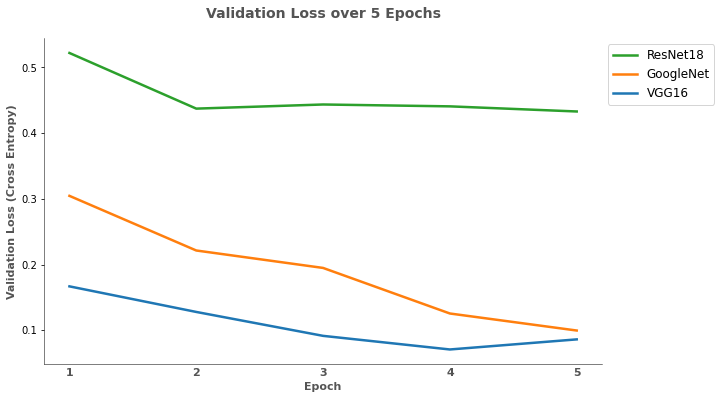

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(vgg_stats['Validation Loss'].values, lw=2.5, label='VGG16')
ax.plot(gnet_stats['Validation Loss'].values, lw=2.5, label='GoogleNet')
ax.plot(resnet_stats['Validation Loss'].values, lw=2.5, label='ResNet18')

ax.set_title('Validation Loss over 5 Epochs', fontsize=14, weight='bold', pad=20, color='#545454')

ax.set_xticklabels(['1', '2', '3', '4', '5'], 
                   fontsize=11, weight='bold', color = '#545454')

plt.xticks(np.arange(0, 5, 1))
ax.tick_params(axis='x', which='both', length=0)
ax.set_xlabel('Epoch', fontsize=11, weight='bold', color='#545454')
ax.set_ylabel('Validation Loss (Cross Entropy)', fontsize=11, weight='bold', color='#545454')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)

plt.show()

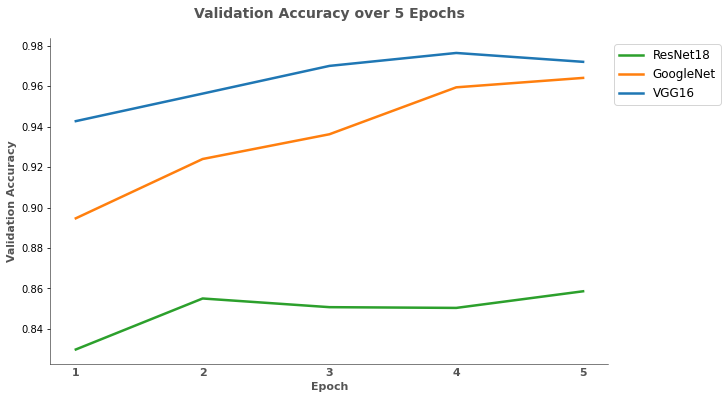

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(vgg_stats['Validation Accuracy'].values, lw=2.5, label='VGG16')
ax.plot(gnet_stats['Validation Accuracy'].values, lw=2.5, label='GoogleNet')
ax.plot(resnet_stats['Validation Accuracy'].values, lw=2.5, label='ResNet18')

ax.set_title('Validation Accuracy over 5 Epochs', fontsize=14, weight='bold', pad=20, color='#545454')
ax.set_xticklabels(['1', '2', '3', '4', '5'], 
                   fontsize=11, weight='bold', color = '#545454')

plt.xticks(np.arange(0, 5, 1))
ax.tick_params(axis='x', which='both', length=0)
ax.set_xlabel('Epoch', fontsize=11, weight='bold', color='#545454')
ax.set_ylabel('Validation Accuracy', fontsize=11, weight='bold', color='#545454')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)

plt.show()

Based on model performance on the validation set, our final model choice is the fine-tuned VGG16 model.

### Train / Test Sets

In [29]:
full_train = pd.concat([train, valid])

In [30]:
ds_full_train = TomatoDataset(full_train, augment=True)
dl_full_train = DataLoader(ds_full_train, batch_size = 10, shuffle=True)

ds_test = TomatoDataset(test)
dl_test = DataLoader(ds_test, batch_size = 10, shuffle=False)

## VGG Model

In [31]:
vgg = models.vgg16(pretrained=True)

In [32]:
vgg.classifier[6] = nn.Linear(in_features=4096, out_features=10) # 10 total classes

In [33]:
lossFun = nn.CrossEntropyLoss()

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

for name, param in vgg.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)

    else:
        param.requires_grad = False

optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

Train final model for 5 epochs.

In [34]:
num_epochs = 5
train_losses_final = []
test_losses_final = []
train_accs_final = []
test_accs_final = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch + 1)
    
    train_loss = one_pass(vgg, dl_full_train, optimizer, lossFun)
    train_losses_final.append(train_loss)
    print('Train loss: ', train_loss)
    
    test_loss = one_pass(vgg, dl_test, optimizer, lossFun, backwards=False)
    test_losses_final.append(test_loss)
    print('Test loss: ', test_loss)
    
    train_acc = one_pass_acc(vgg, dl_full_train, len(ds_full_train))
    train_accs_final.append(train_acc)
    test_acc = one_pass_acc(vgg, dl_test, len(ds_test))
    test_accs_final.append(test_acc)
    print('Train accuracy: ', train_acc)
    print('Test accuracy: ', test_acc)
    print('----------------------------------')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1


  0%|          | 0/4383 [00:00<?, ?it/s]

Train loss:  0.3847975426360234


  0%|          | 0/1096 [00:00<?, ?it/s]

Test loss:  0.1405260158637409


  0%|          | 0/4383 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.9691050974307489
Test accuracy:  0.9523592224148946
----------------------------------
Epoch:  2


  0%|          | 0/4383 [00:00<?, ?it/s]

Train loss:  0.11954673418693597


  0%|          | 0/1096 [00:00<?, ?it/s]

Test loss:  0.09832474405682352


  0%|          | 0/4383 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.986332314151417
Test accuracy:  0.9678744181801588
----------------------------------
Epoch:  3


  0%|          | 0/4383 [00:00<?, ?it/s]

Train loss:  0.060861491238252456


  0%|          | 0/1096 [00:00<?, ?it/s]

Test loss:  0.08731723489542412


  0%|          | 0/4383 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.9908273627527039
Test accuracy:  0.9720726476225244
----------------------------------
Epoch:  4


  0%|          | 0/4383 [00:00<?, ?it/s]

Train loss:  0.03221886535274724


  0%|          | 0/1096 [00:00<?, ?it/s]

Test loss:  0.05683839435809648


  0%|          | 0/4383 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.9983343220919089
Test accuracy:  0.9834808798028658
----------------------------------
Epoch:  5


  0%|          | 0/4383 [00:00<?, ?it/s]

Train loss:  0.023930832090216902


  0%|          | 0/1096 [00:00<?, ?it/s]

Test loss:  0.052534434413967865


  0%|          | 0/4383 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Train accuracy:  0.998653767170173
Test accuracy:  0.9836634115177512
----------------------------------


Save final model:

In [35]:
checkpoint_final = {'model_state_dict': vgg.state_dict(),
              'optimizer_state_dict' :optimizer.state_dict()}
torch.save(checkpoint_final, '/kaggle/working/final_model_checkpoint.pt')